In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import os
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Reshape, Flatten, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
train_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train'
vali_p = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/val'

In [3]:
class_labels = []

for item in train_p:
 all_classes = os.listdir('/Users/admin/Downloads/DSGP/Fruit Dataset_S/train' + '/' +item)

for room in all_classes:
    class_labels.append((item, str('train_p' + '/' +item) + '/' + room))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/admin/Downloads/DSGP/Fruit Dataset_S/train/U'

Found 5280 files belonging to 3 classes.


2024-02-12 06:42:04.158105: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-12 06:42:04.158138: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-12 06:42:04.158147: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-12 06:42:04.158216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 06:42:04.158386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    vali_p,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=img_size,
    label_mode="categorical",
)

Found 660 files belonging to 3 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Over Ripe', 'Ripe', 'Unripe']


TypeError: only integer scalar arrays can be converted to a scalar index

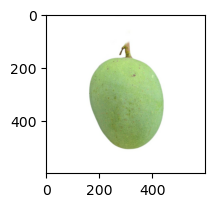

In [7]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [9]:
efficientnet_model = Sequential()

pretrained_m =tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(600,600,3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)
for layer in pretrained_m.layers:
    layer.trainable = False
    
efficientnet_model.add(pretrained_m)
efficientnet_model.add(BatchNormalization())
efficientnet_model.add(GlobalAveragePooling2D())
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(256, activation='relu'))
efficientnet_model.add(Dropout(0.2))
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dropout(0.2))
efficientnet_model.add(Dense(64, activation='relu'))
efficientnet_model.add(Dropout(0.2))
efficientnet_model.add(Dense(3, activation='softmax'))

In [10]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 19, 19, 2560)      64097687  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 19, 19, 2560)      10240     
 chNormalization)                                                
                                                                 
 module_wrapper_9 (ModuleWr  (None, 2560)              0         
 apper)                                                          
                                                                 
 module_wrapper_10 (ModuleW  (None, 2560)              0         
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 256)              

In [11]:
efficientnet_model.compile(optimizer=LegacyAdam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,          
    restore_best_weights=True, 
)

In [ ]:
history = efficientnet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3,
    callbacks = [early_stopping],
)

Epoch 1/3


2024-02-12 06:42:48.679504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/165 [==============================] - 732s 4s/step - loss: 0.6213 - accuracy: 0.8481 - val_loss: 0.3372 - val_accuracy: 0.9091
Epoch 2/3
 40/165 [======>.......................] - ETA: 8:14 - loss: 0.8803 - accuracy: 0.8609

In [ ]:
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=2)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
test_dataset = '/Users/admin/Downloads/DSGP/Fruit Dataset_S/test'

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

In [ ]:
predictions = efficientnet_model.predict(test_generator)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = efficientnet_model.evaluate(test_generator, batch_size=BATCH_SIZE)

In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()